In [21]:
!pip install kneed

In [22]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [23]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [24]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    
price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [25]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [26]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
AAPL    0.192985    0.263768
ADBE    0.044761    0.363280
ADI     0.133117    0.307354
ADP     0.164773    0.214581
ADSK    0.065313    0.358144

Beschreibung der Metriken:
         returns  volatility
count  94.000000   94.000000
mean    0.149393    0.354886
std     0.156041    0.142551
min    -0.189049    0.164362
25%     0.052293    0.236353
50%     0.131296    0.329170
75%     0.227251    0.425105
max     0.848285    0.982195


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [27]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [28]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
AAPL    0.280860   -0.642626
ADBE   -0.674136    0.059197
ADI    -0.104866   -0.335225
ADP     0.099091   -0.989523
ADSK   -0.541723    0.022977

Beschreibung der skalierten Daten:
            returns    volatility
count  9.400000e+01  9.400000e+01
mean  -1.830687e-17 -6.141659e-17
std    1.005362e+00  1.005362e+00
min   -2.180562e+00 -1.343697e+00
25%   -6.256107e-01 -8.359697e-01
50%   -1.165985e-01 -1.813643e-01
75%    5.016335e-01  4.952276e-01
max    4.502918e+00  4.424190e+00


In [29]:
def get_top_pairs(X, ap, price_matrix, min_pairs=20, p_threshold=0.05):
    scores = []
    
    for cluster_id in np.unique(ap.labels_):
        cluster_mask = ap.labels_ == cluster_id
        cluster_symbols = X.index[cluster_mask]
        center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
        
        for i in range(len(cluster_symbols)):
            for j in range(i+1, len(cluster_symbols)):
                symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                
                dist1 = np.linalg.norm(X.loc[symbol1] - center)
                dist2 = np.linalg.norm(X.loc[symbol2] - center)
                center_dist = (dist1 + dist2) / 2
                
                profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                
                series1 = price_matrix[symbol1]
                series2 = price_matrix[symbol2]
                score, pvalue, _ = coint(series1, series2)
                
                if pvalue < p_threshold:
                    scores.append({
                        'pair': (symbol1, symbol2),
                        'center_dist': center_dist,
                        'profile_diff': profile_diff,
                        'pvalue': pvalue,
                        'cluster': cluster_id
                    })

    scores_df = pd.DataFrame(scores)

    scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                   (scores_df['center_dist'].max() - scores_df['center_dist'].min())
    scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                    (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())

    scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                 0.4 * scores_df['profile_diff_norm']
    
    scores_df = scores_df.sort_values('combined_score')
    
    while len(scores_df) < min_pairs and p_threshold < 0.1:
        p_threshold += 0.05
        scores = []
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    score, pvalue, _ = coint(series1, series2)
                    
                    if pvalue < p_threshold:
                        scores.append({
                            'pair': (symbol1, symbol2),
                            'center_dist': center_dist,
                            'profile_diff': profile_diff,
                            'pvalue': pvalue,
                            'cluster': cluster_id
                        })
        
        scores_df = pd.DataFrame(scores)
        if len(scores) > 0:
            scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                          (scores_df['center_dist'].max() - scores_df['center_dist'].min())
            scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                           (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())
            scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                        0.4 * scores_df['profile_diff_norm']
            scores_df = scores_df.sort_values('combined_score')
    
    print(f"Found {len(scores_df)} pairs with p-value < {p_threshold}")
    return scores_df['pair'].tolist()[:min_pairs], scores_df[:min_pairs]

# Affinity Propagation Clustering

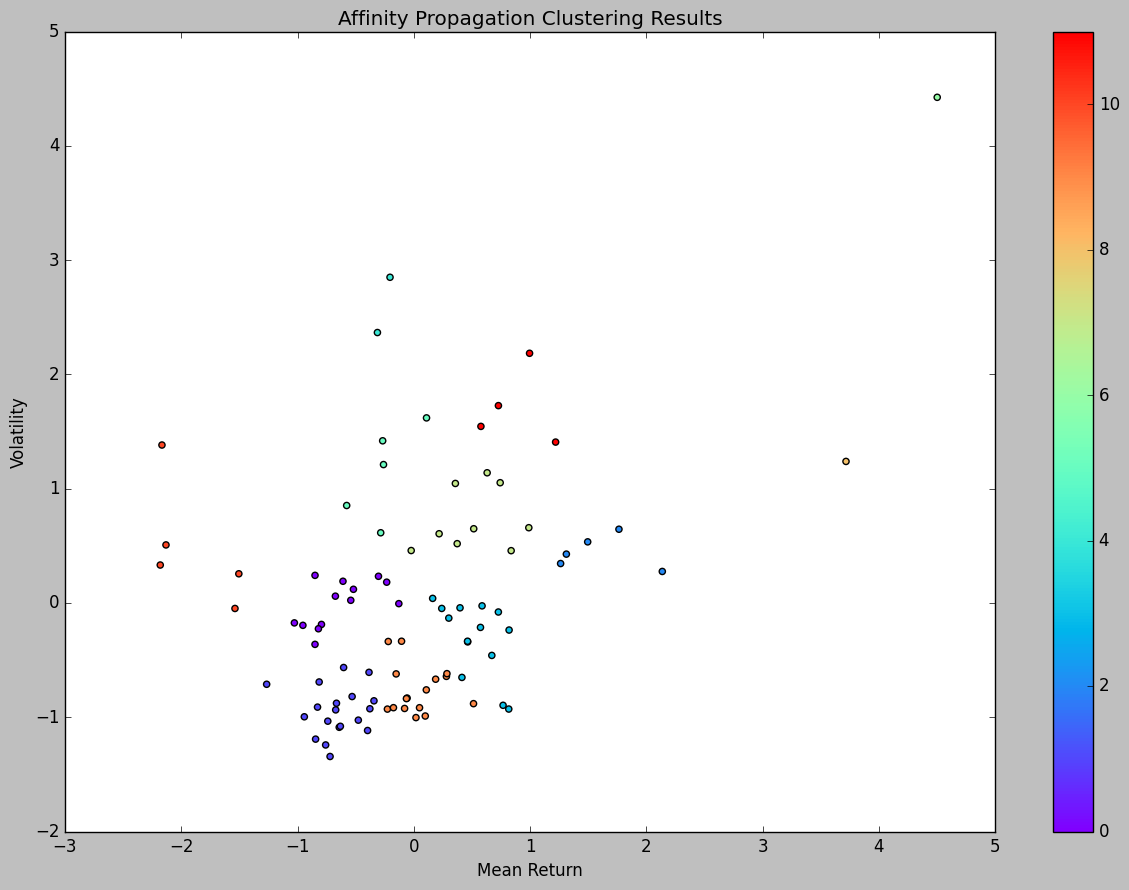

Found 45 pairs with p-value < 0.05

Top pairs details:
             pair  center_dist  profile_diff    pvalue  combined_score  \
29  (GOOG, GOOGL)     0.003008      0.006015  0.040186        0.000000   
14     (CSX, XEL)     0.089171      0.173654  0.040346        0.172169   
9       (CSX, EA)     0.108372      0.166515  0.036604        0.189541   
39    (ADP, TMUS)     0.197757      0.087837  0.043912        0.248972   
10     (CSX, EXC)     0.136349      0.239079  0.049217        0.253999   
41    (LIN, PCAR)     0.129149      0.258298  0.033792        0.255290   
20     (EXC, HON)     0.181675      0.163520  0.024911        0.267310   
16      (EA, HON)     0.153698      0.258477  0.004449        0.281893   
8     (CSX, CTSH)     0.170576      0.238415  0.000568        0.290658   
40   (FAST, MSFT)     0.155232      0.303268  0.017249        0.304682   
12     (CSX, KHC)     0.167519      0.300825  0.047635        0.316802   
2    (ANSS, TTWO)     0.297545      0.046172  0.017456   

In [30]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X) #1

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

top_pairs, scores_df = get_top_pairs(X, ap, price_matrix, min_pairs=20)

print("\nTop pairs details:")
print(scores_df[['pair', 'center_dist', 'profile_diff', 'pvalue', 'combined_score', 'cluster']])

The number of clusters is: 12


<Figure size 1200x600 with 0 Axes>

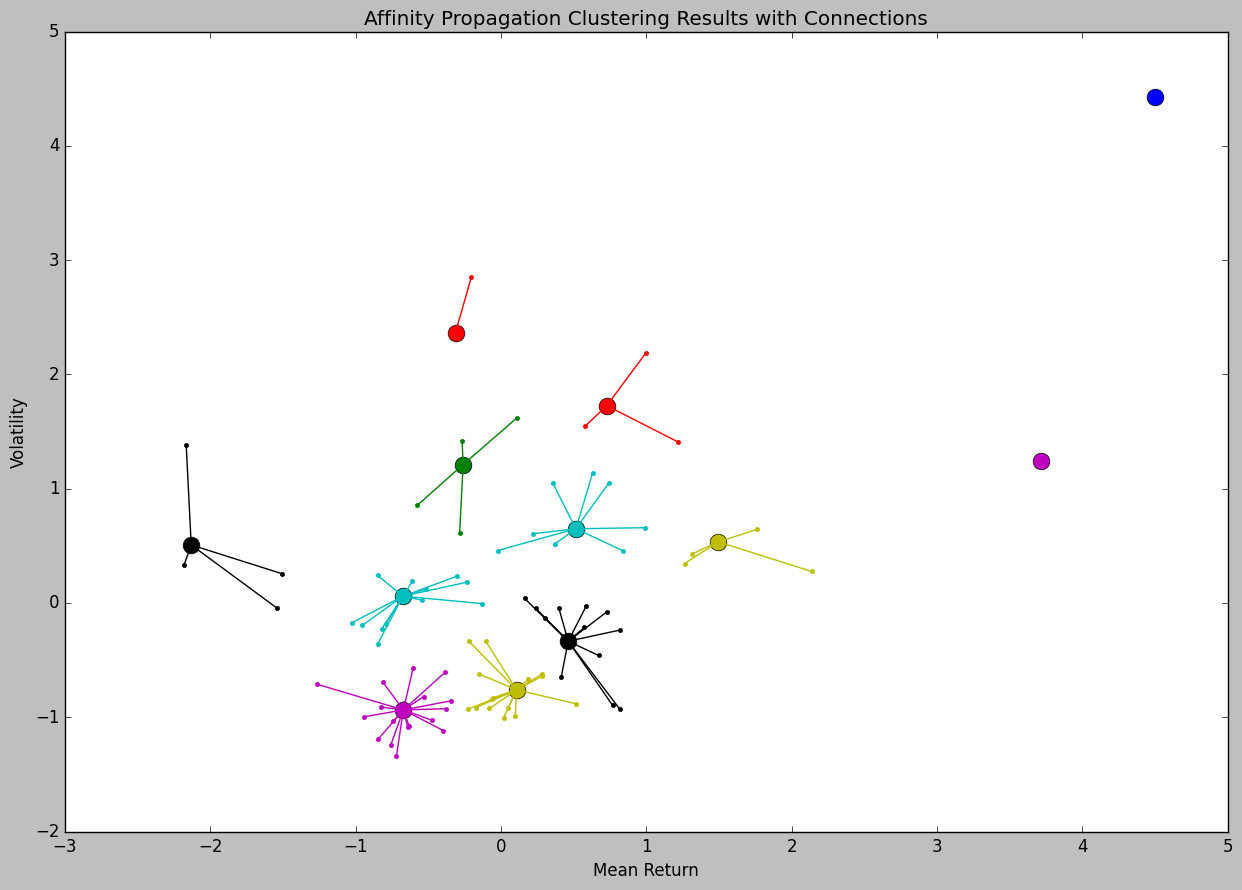

In [31]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [32]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

Number of clusters: 10
Number of Pairs: 1066


Analyzing pairs: 100%|██████████| 78/78 [00:01<00:00, 76.38it/s]



Analysis complete!
Found 6 cointegrated pairs
Total pairs analyzed: 78

Cluster 0 pairs:
ADSK - TTWO
AMZN - TTWO
ANSS - TTWO
ANSS - WDAY
CSGP - MCHP
TTWO - WDAY


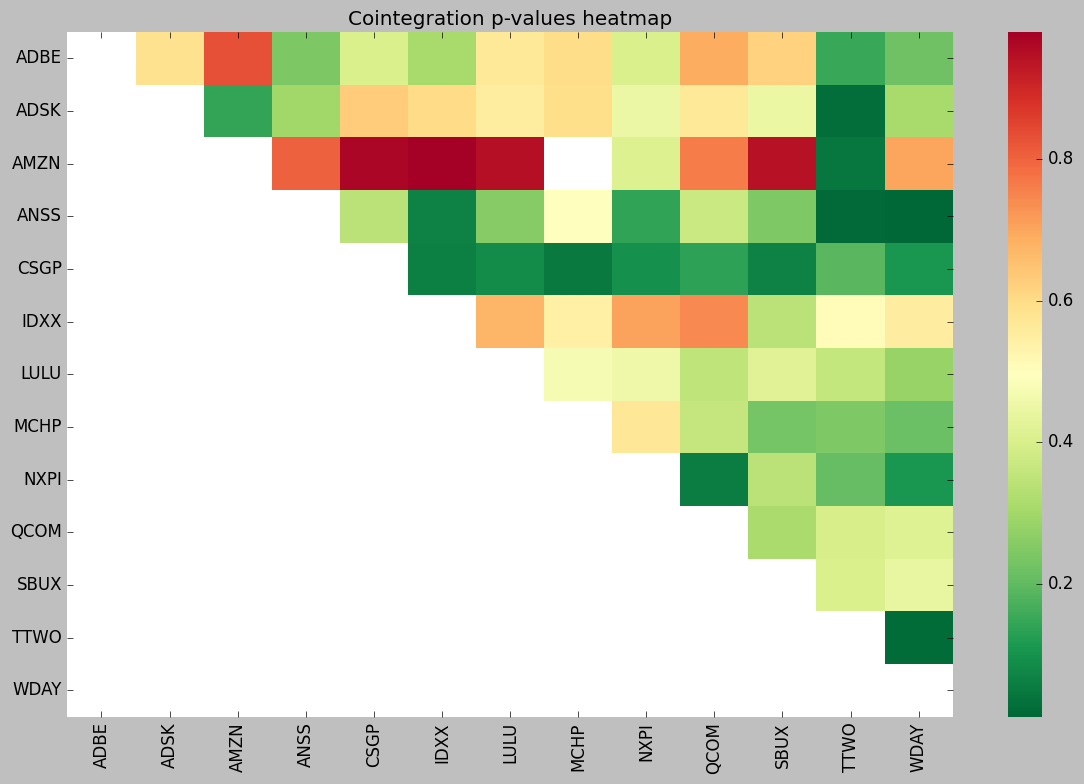

Analyzing pairs: 100%|██████████| 171/171 [00:02<00:00, 72.30it/s]



Analysis complete!
Found 20 cointegrated pairs
Total pairs analyzed: 171

Cluster 1 pairs:
CDW - KDP
CDW - XEL
CSX - CTSH
CSX - EA
CSX - EXC
CSX - KDP
CSX - KHC
CSX - ROP
CSX - XEL
EA - EXC
EA - HON
EA - PEP
EA - ROP
EA - TXN
EXC - HON
HON - PEP
HON - TXN
KDP - MNST
KDP - ROP
KHC - ROP


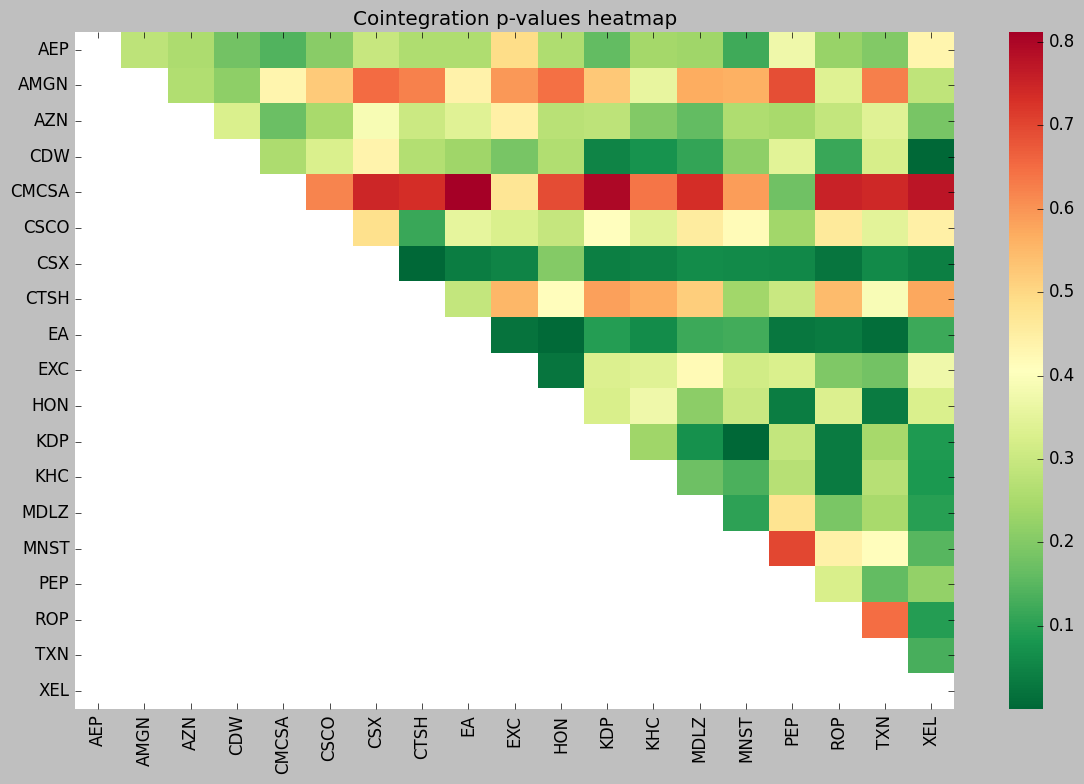

Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 71.95it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 10

Cluster 2 pairs:
AVGO - AXON


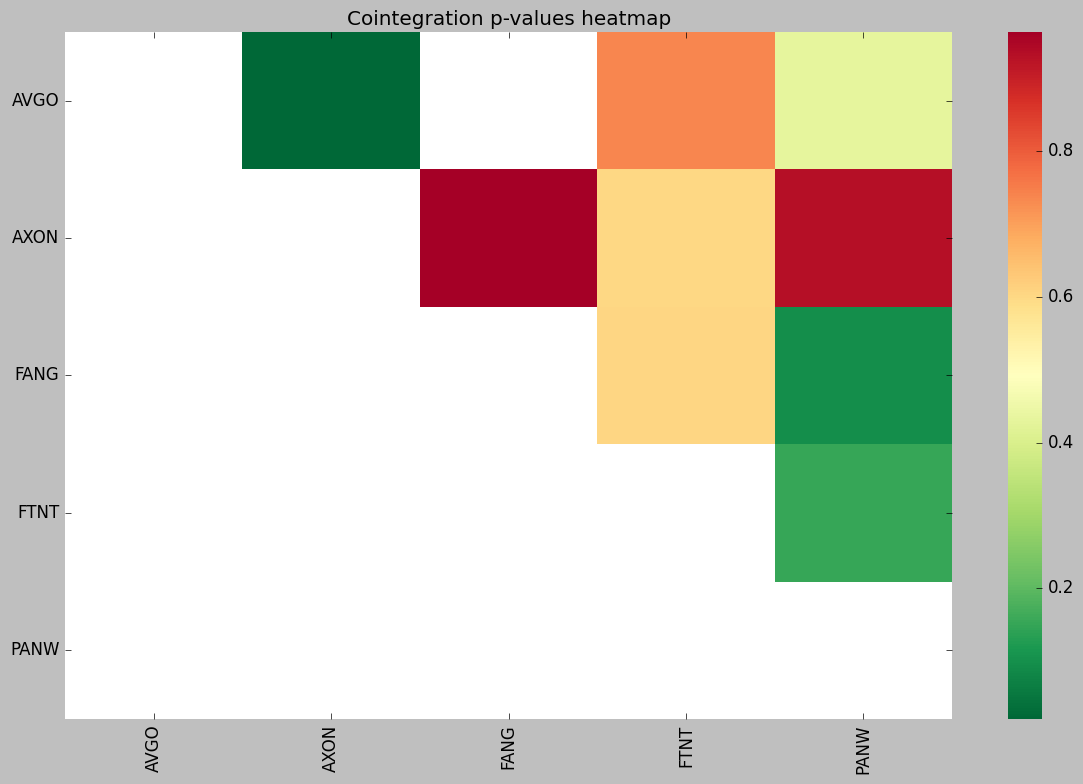

Analyzing pairs: 100%|██████████| 91/91 [00:01<00:00, 76.37it/s]



Analysis complete!
Found 7 cointegrated pairs
Total pairs analyzed: 91

Cluster 3 pairs:
CDNS - CPRT
CDNS - ORLY
GOOG - GOOGL
GOOG - TSM
GOOGL - TSM
ISRG - TSM
ODFL - SNPS


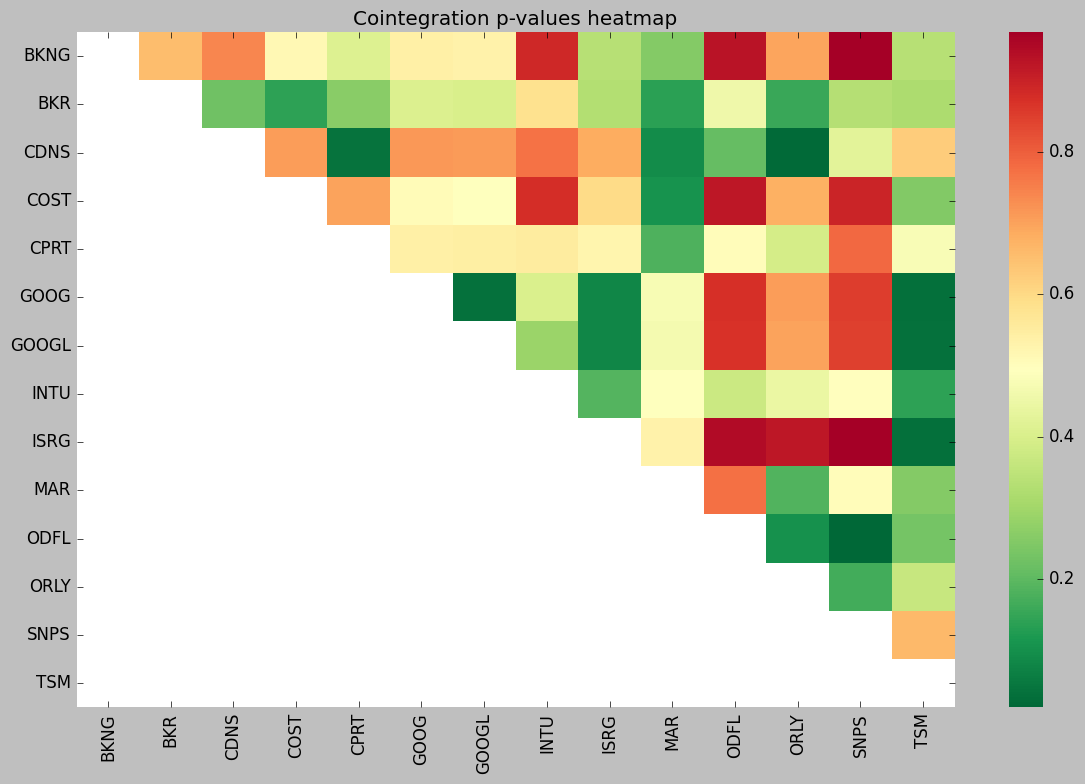

Analyzing pairs: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 1


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 73.43it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 10


Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 74.45it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 36


Analyzing pairs: 100%|██████████| 120/120 [00:01<00:00, 72.93it/s]



Analysis complete!
Found 10 cointegrated pairs
Total pairs analyzed: 120

Cluster 9 pairs:
ADI - CCEP
ADI - CTAS
ADI - LIN
ADI - MSFT
ADI - VRSK
ADP - TMUS
FAST - MSFT
LIN - PCAR
MSFT - VRSK
REGN - VRTX


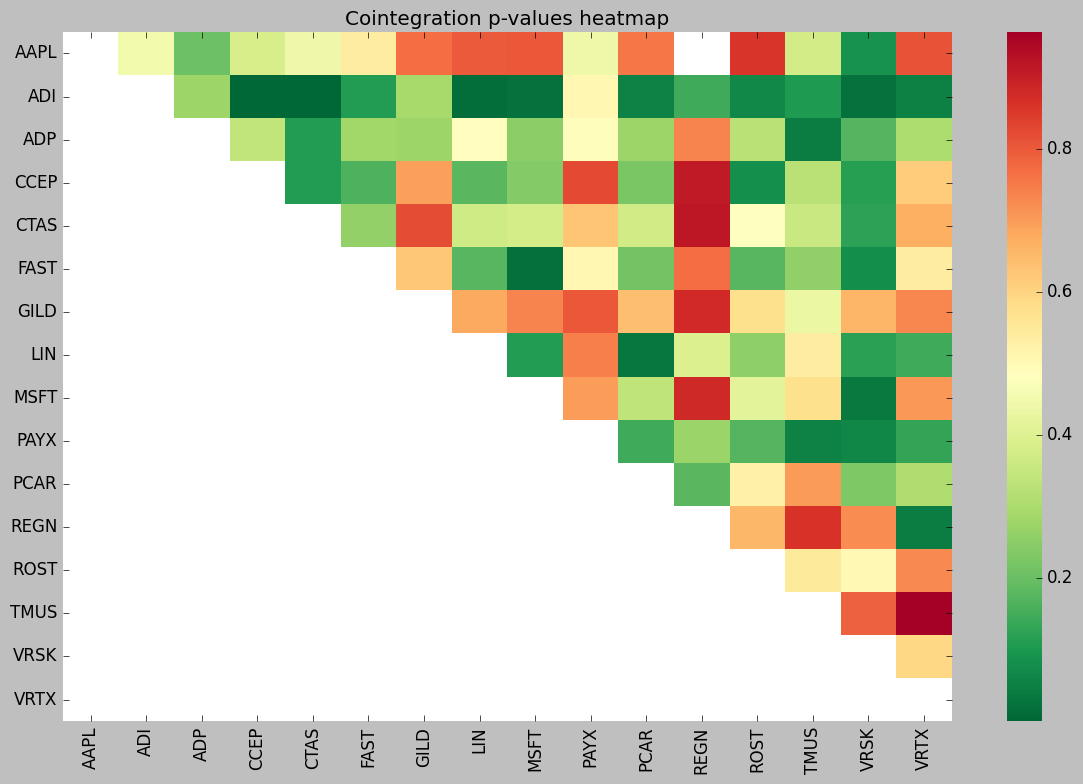

Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 70.99it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 10


Analyzing pairs: 100%|██████████| 6/6 [00:00<00:00, 73.08it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 6

Cluster 11 pairs:
MRVL - TTD


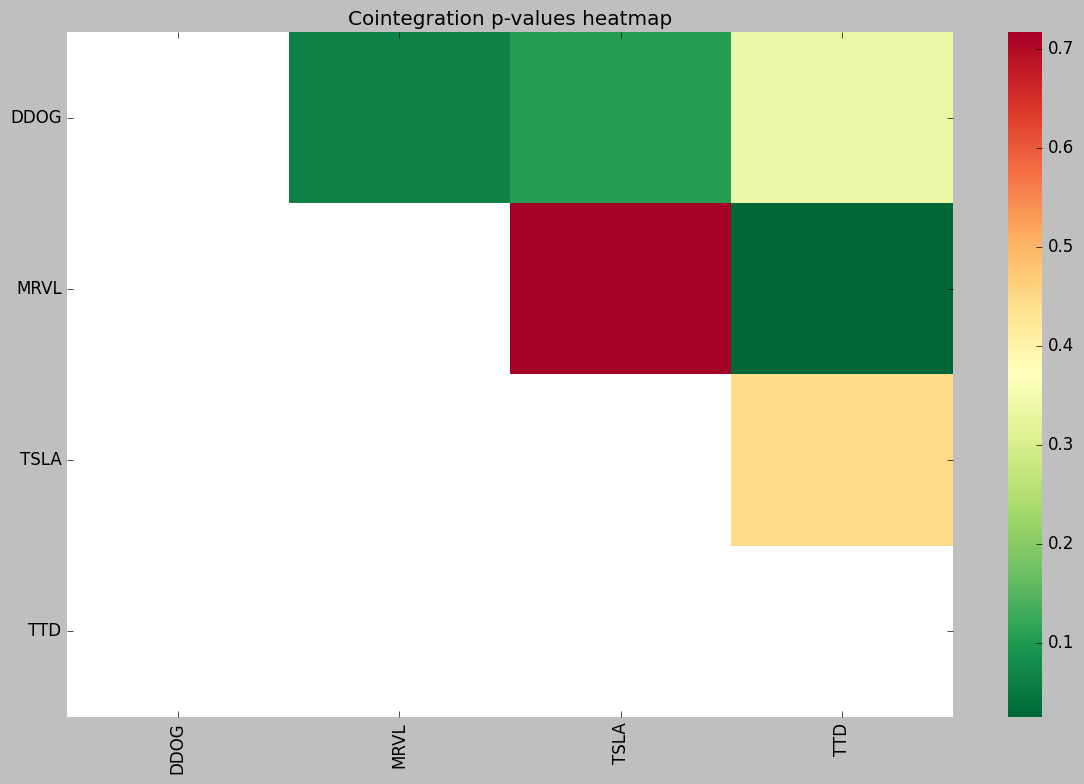

In [33]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=0.05
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [34]:
stocks = np.unique([stock for pair in top_pairs for stock in pair])
X_data = pd.DataFrame(index=X.index, data=X).T  
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
X_pairs = X_data.T.loc[stocks]

In [35]:

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

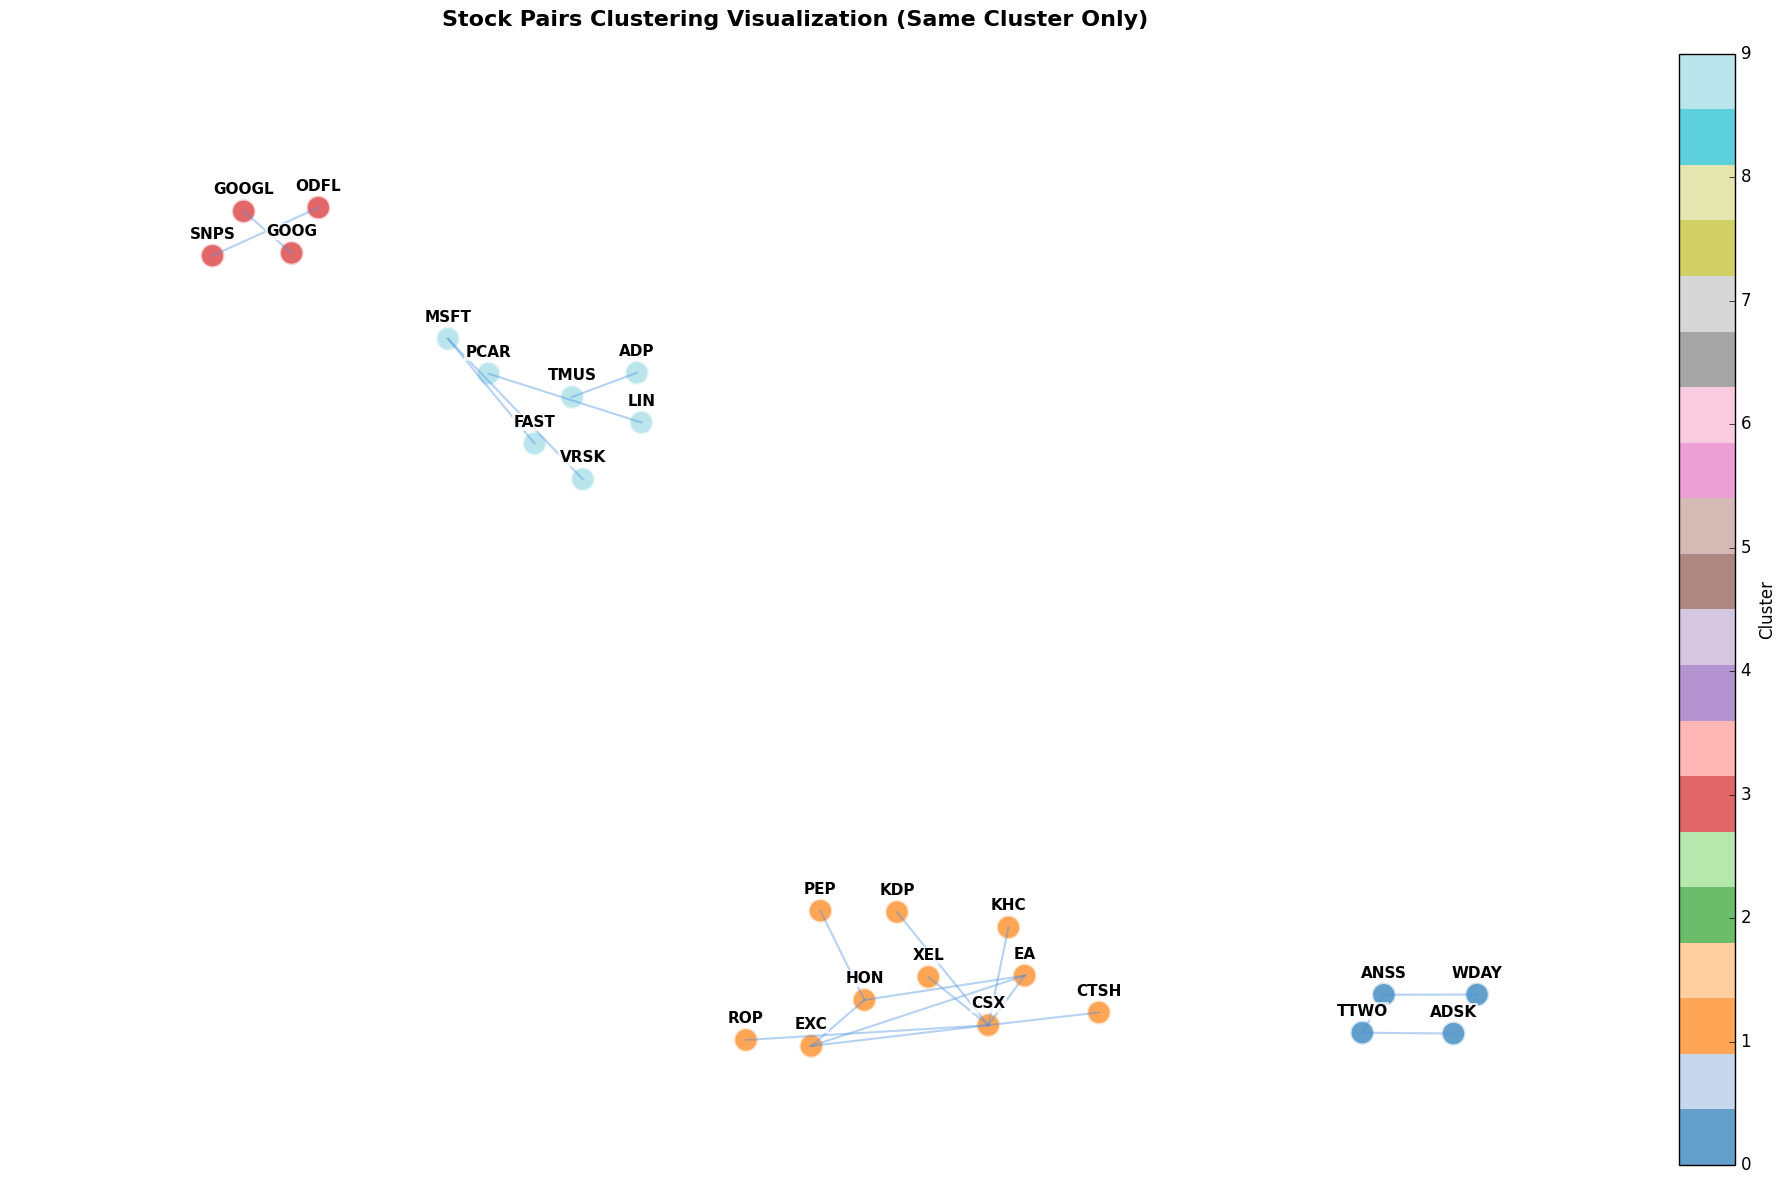

In [36]:

plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

for pair in top_pairs:
    cluster = scores_df[scores_df['pair'] == pair]['cluster'].values[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='#4a90e2')

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     c=in_pairs_series.values,
                     cmap='tab20',
                     edgecolor='white',
                     linewidth=2)

for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.7,
                         pad=1))

plt.title('Stock Pairs Clustering Visualization (Same Cluster Only)', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.axis('off')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [37]:
def zscore(series):    
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    # Calculate ratio and z-score
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window1=5, window2=60):
    ratios_train = S1_train / S2_train
    ma2_train = ratios_train.rolling(window=window2, center=False).mean()
    std_train = ratios_train.rolling(window=window2, center=False).std()
    
    ratios_test = S1_test / S2_test
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    for i in range(len(ratios_test)):
        current_ratio = ratios_test.iloc[i]
        current_date = ratios_test.index[i]
        
        ma2_test = ratios_test.iloc[:i+1].rolling(window=window2, center=False).mean().iloc[-1]
        std_test = ratios_test.iloc[:i+1].rolling(window=window2, center=False).std().iloc[-1]
        zscore = (current_ratio - ma2_test) / std_test
        
        if position == 0:
            if zscore > 1.0:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "short"},
                    symbol2: {"price": S2_test.iloc[i], "type": "long"}
                }
                position = -1
                
            elif zscore < -1.0:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "long"},
                    symbol2: {"price": S2_test.iloc[i], "type": "short"}
                }
                position = 1
                
        elif abs(zscore) < 0.5 and position != 0:
            for symbol in [symbol1, symbol2]:
                trades.append({
                    'trade_id': trade_id,
                    'symbol': symbol,
                    'entry_date': entry_date,
                    'entry_price': entry_prices[symbol]["price"],
                    'exit_date': current_date,
                    'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                    'position_type': entry_prices[symbol]["type"],
                    'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                    'exit_type': 'target'
                })
            position = 0
            trade_id += 1
            
    return trades

def backtest_pairs(price_matrix, pairs, train_end_date):
    all_trades = []
    
    for symbol1, symbol2 in pairs:
        training_mask = price_matrix.index < train_end_date
        
        S1_train = price_matrix[symbol1][training_mask]
        S2_train = price_matrix[symbol2][training_mask]
        S1_test = price_matrix[symbol1][~training_mask]
        S2_test = price_matrix[symbol2][~training_mask]
        
        pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
        all_trades.extend(pair_trades)
    
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('../../data/results/Cluster_Z-Score_static.parquet')
    
    return trades_df

In [38]:
trades_df = backtest_pairs(price_matrix, top_pairs, DATE_CONFIG['TRAIN_END'])

### Debug 🛠️

In [39]:
print("Gefundene Top Pairs:")
for pair in top_pairs:
    print(f"{pair[0]} - {pair[1]}")
print(f"\nAnzahl der Top Pairs: {len(top_pairs)}")

Gefundene Top Pairs:
GOOG - GOOGL
CSX - XEL
CSX - EA
ADP - TMUS
CSX - EXC
LIN - PCAR
EXC - HON
EA - HON
CSX - CTSH
FAST - MSFT
CSX - KHC
ANSS - TTWO
ODFL - SNPS
CSX - KDP
EA - EXC
CSX - ROP
ADSK - TTWO
ANSS - WDAY
HON - PEP
MSFT - VRSK

Anzahl der Top Pairs: 20
